In [5]:
import string

from matplotlib import pyplot as plt
%matplotlib inline

from data.generate_data import generate_yolo_train_data


During training we use Keras' fit_generator. The generator generates an image with one ore more characters on it and the 3 corresponding output tensors to it.

In [2]:

batch_size = 5
cell_sizes = [16, 8, 4]
anchor_boxes = [(64, 64), (32, 32), (16, 16)]

chars_list = list(string.ascii_letters)
chars_list.extend(list(string.digits))
n_classes = len(chars_list)


We set the parameters: batch size, pixel size of grids we predict in, anchor box sizes we use at different scales, list of chars we want to generate, font and size of the chars and the size of the image.

In [3]:
train_data_generator = generate_yolo_train_data(batch_size, cell_sizes,
                                                anchor_boxes, chars_list, ['arial'], (50, 100), (416,416))
images, out_tensors = next(train_data_generator)

It generates images:

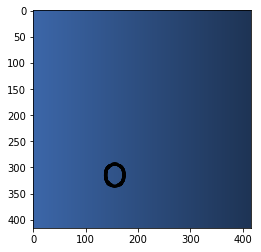

In [6]:
plt.imshow(images[0])
plt.show()

And corresponding output tensors:

In [ ]:
out1, out2, out3 = out_tensors
print('Grid size in the 1st scale: {} by {}'.format(out1[0].shape[1], out1[0].shape[0]))
print('Grid size in the 2nd scale: {} by {}'.format(out2[0].shape[1], out2[0].shape[0]))
print('Grid size in the 3rd scale: {} by {}'.format(out3[0].shape[1], out3[0].shape[0]))

print('\nPredicted values per cell: {}'.format(out1[0].shape[2]))
